# Load packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import brier_score_loss

import xgboost as xgb
from xgboost import XGBClassifier

# Load data

In [2]:
all_games_df = pd.read_csv('Data/~Created data/all_games_df.csv')

In [3]:
test_combos_df = pd.read_csv('Data/~Created data/test_combos_df_19.csv')
test_combos_df = test_combos_df.sort_values(by=['ID']).reset_index(drop=True)

In [4]:
test_combos_df.head()

,Season,ID,HTeamID,RTeamID,HSeed,RSeed,is_tourney,Hwins_top25,HPointMargin,HFG,...,road,Rconf,Radjem,Radjo,Radjd,Rluck,Htourny20plus,Rtourny20plus,HBig4Conf,RBig4Conf
0,2019,2019_1101_1113,1113.0,1101.0,11.0,15.0,1,2,4.750000,0.450937,...,abilene christian,Slnd,2.09,103.6,101.5,0.087,0,0,0,0
1,2019,2019_1101_1120,1120.0,1101.0,5.0,15.0,1,3,10.294118,0.447579,...,abilene christian,Slnd,2.09,103.6,101.5,0.087,0,0,1,0
2,2019,2019_1101_1124,1124.0,1101.0,9.0,15.0,1,3,4.468750,0.442081,...,abilene christian,Slnd,2.09,103.6,101.5,0.087,0,0,1,0
3,2019,2019_1101_1125,1125.0,1101.0,11.0,15.0,1,0,12.200000,0.500653,...,abilene christian,Slnd,2.09,103.6,101.5,0.087,0,0,0,0
4,2019,2019_1101_1133,1101.0,1133.0,15.0,15.0,1,0,6.827586,0.458861,...,bradley,MVC,-0.36,100.9,101.2,0.040,0,0,0,0


In [5]:
test_combos_df.tail()

,Season,ID,HTeamID,RTeamID,HSeed,RSeed,is_tourney,Hwins_top25,HPointMargin,HFG,...,road,Rconf,Radjem,Radjo,Radjd,Rluck,Htourny20plus,Rtourny20plus,HBig4Conf,RBig4Conf
2273,2019,2019_1449_1459,1459.0,1449.0,7.0,9.0,1,0,13.666667,0.487256,...,washington,P12,13.37,107.0,93.6,0.078,0,0,0,0
2274,2019,2019_1449_1463,1449.0,1463.0,9.0,14.0,1,0,5.441176,0.455797,...,yale,Ivy,8.59,111.7,103.1,0.057,0,0,0,0
2275,2019,2019_1458_1459,1458.0,1459.0,5.0,7.0,1,2,7.636364,0.453714,...,wofford,SC,20.71,118.4,97.6,0.060,1,0,1,0
2276,2019,2019_1458_1463,1458.0,1463.0,5.0,14.0,1,2,7.636364,0.453714,...,yale,Ivy,8.59,111.7,103.1,0.057,1,0,1,0
2277,2019,2019_1459_1463,1459.0,1463.0,7.0,14.0,1,0,13.666667,0.487256,...,yale,Ivy,8.59,111.7,103.1,0.057,0,0,0,0


In [6]:
ind_var_selected = [
'is_tourney', 
'HRankPOM',
'RRankPOM',
'line',
'Hwins_top25',
'Rwins_top25',
'HPointMargin',
'RPointMargin',
'HFG',
'RFG',
'HFG3',
'RFG3',
'Hadjem',
'Hadjo',
'Hadjd',
'Hluck',
'Radjem',
'Radjo',
'Radjd',
'Rluck',
'Htourny20plus',
'Rtourny20plus',
'HBig4Conf',
'RBig4Conf', 
'HSeed',
'RSeed'
]

Note: test is 2019 predictions but our "test" holdout set is referred to as "valid" 

In [7]:
#prediction set 2019
test_ids = test_combos_df['ID'].reset_index(drop=True)
X_test = test_combos_df[['is_tourney','HRankPOM','RRankPOM','Hwins_top25','Rwins_top25','HPointMargin','RPointMargin','HFG','RFG','HFG3','RFG3','Hadjem','Hadjo','Hadjd','Hluck','Radjem','Radjo','Radjd','Rluck','Htourny20plus','Rtourny20plus','HBig4Conf','RBig4Conf','HSeed','RSeed']].reset_index(drop=True)

In [8]:
#Predict the last two years as a test set (2017, 2018):
temp_df = all_games_df[all_games_df['Season']>2016]
temp_df = temp_df[temp_df['is_tourney']==1]
X_valid = temp_df[ind_var_selected].reset_index(drop=True)
y_valid = temp_df['Hwin'].reset_index(drop=True)

#Train on everything else:
temp_df1 = all_games_df[all_games_df['Season']>2016]
temp_df1 = temp_df1[temp_df1['is_tourney']==0]
temp_df2 = all_games_df[all_games_df['Season']<2017]
combined_temp_df = temp_df1.append(temp_df2)

X_train = combined_temp_df[ind_var_selected].reset_index(drop=True)
y_train = combined_temp_df['Hwin'].reset_index(drop=True)

#For final predictions:
X_train_orig = all_games_df[ind_var_selected].reset_index(drop=True)
y_train_orig = all_games_df['Hwin'].reset_index(drop=True)

In [9]:
#Create second holdout set to double-check not overfit and check model stability (season 2016)
temp_df16 = all_games_df[all_games_df['Season']==2016]
temp_df16 = temp_df16[temp_df16['is_tourney']==1]
X_valid16 = temp_df16[ind_var_selected].reset_index(drop=True)
y_valid16 = temp_df16['Hwin'].reset_index(drop=True)

temp_df1_16 = all_games_df[all_games_df['Season']==2016]
temp_df1_16 = temp_df1_16[temp_df1_16['is_tourney']==0]
temp_df2_16 = all_games_df[all_games_df['Season']!=2016]
combined_temp_df_16 = temp_df1_16.append(temp_df2_16)

X_train16 = combined_temp_df_16[ind_var_selected].reset_index(drop=True)
y_train16 = combined_temp_df_16['Hwin'].reset_index(drop=True)

In [10]:
X_test = X_test.astype("float64")

X_train_orig = X_train_orig.astype("float64")
y_train_orig = y_train_orig.astype("float64")

X_train = X_train.astype("float64")
X_valid = X_valid.astype("float64")
y_train = y_train.astype("float64")
y_valid = y_valid.astype("float64")

X_train16 = X_train16.astype("float64")
X_valid16 = X_valid16.astype("float64")
y_train16 = y_train16.astype("float64")
y_valid16 = y_valid16.astype("float64")

# Scoring rules and two benchmarks

In [11]:
def LogLoss(predictions, realizations):
    predictions_use = predictions.clip(0)
    realizations_use = realizations.clip(0)
    LogLoss = -np.mean( (realizations_use * np.log(predictions_use)) + 
                        (1 - realizations_use) * np.log(1 - predictions_use) )
    return LogLoss

If the model doesn't beat assuming 50% it is poor

In [12]:
bench_5050 = np.repeat(0.5, len(y_valid))

In [13]:
LogLoss(bench_5050, y_valid)

0.6931471805599462

How does this compare to Lopez and Matthews (2014 winners)?

In [14]:
Z1 = LogisticRegression(C = 1e9, random_state=23)
Z1.fit(X_train[['line']], y_train)
Z1_pred = pd.DataFrame(Z1.predict_proba(X_valid[['line']]))[1]

In [15]:
LogLoss(Z1_pred, y_valid)

0.5502080536043085

In [16]:
Z2 = LogisticRegression(C = 1e9, random_state=23)
Z2.fit(X_train[['Hadjo','Hadjd','Radjo','Radjd']], y_train)
Z2_pred = pd.DataFrame(Z2.predict_proba(X_valid[['Hadjo','Hadjd','Radjo','Radjd']]))[1]

In [17]:
LogLoss(Z2_pred, y_valid)

0.5354193605374048

In [18]:
Z1 = LogisticRegression(C = 1e9, random_state=23)
Z1.fit(X_train16[['line']], y_train16)
Z1_pred = pd.DataFrame(Z1.predict_proba(X_valid16[['line']]))[1]

In [19]:
LogLoss(Z1_pred, y_valid16)

0.5380322975323194

In [20]:
Z2 = LogisticRegression(C = 1e9, random_state=23)
Z2.fit(X_train16[['Hadjo','Hadjd','Radjo','Radjd']], y_train16)
Z2_pred = pd.DataFrame(Z2.predict_proba(X_valid16[['Hadjo','Hadjd','Radjo','Radjd']]))[1]

In [21]:
LogLoss(Z2_pred, y_valid16)

0.5223623202955376

# Fit a neural network (with and without line)

Normalize data (using z-scores) before neural network

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)  # Fit only to the training data
scaled_X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
scaled_X_valid = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)

In [23]:
scaler = StandardScaler()
scaler.fit(X_train16)  # Fit only to the training data
scaled_X_train16 = pd.DataFrame(scaler.transform(X_train16), index=X_train16.index, columns=X_train16.columns)
scaled_X_valid16 = pd.DataFrame(scaler.transform(X_valid16), index=X_valid16.index, columns=X_valid16.columns)

In [24]:
#drop line from training since we won't use in predictions, need these to be same number of columns.
X_train_orig = X_train_orig.drop(['line'], axis=1)

In [25]:
scaler = StandardScaler()
scaler.fit(X_train_orig)  # Fit to all training data

scaled_X_train_orig = pd.DataFrame(scaler.transform(X_train_orig), index=X_train_orig.index, columns=X_train_orig.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

With line (note: we won't have line in the rounds after the first, but we could use this for the first round only like Lopez and Matthews did) 

In [26]:
#Note: I tried logistic activation and different combinations of hidden layers/nodes
#Hyperparameters below minimized the log loss in the holdout set
#I also submited a prediction with 10 nodes in the first layer, but this is the submission that placed 4th (w/ 8 in 1st)
nn = MLPClassifier(activation='relu', hidden_layer_sizes=(8,5,3),random_state=201, max_iter=1000)
nn.fit(scaled_X_train,y_train)
nn_pred = pd.DataFrame(nn.predict_proba(scaled_X_valid))[1]

In [27]:
LogLoss(nn_pred, y_valid)

0.48567514848578824

In [28]:
#try second holdout (does worse, but still better than baseline of 54)
nn.fit(scaled_X_train16,y_train16)
nn_pred16 = pd.DataFrame(nn.predict_proba(scaled_X_valid16))[1]
LogLoss(nn_pred16, y_valid16)

0.5314306526723535

Without line

In [29]:
#Note: I tried logistic activation and different combinations of hidden layers/nodes
#Hyperparameters below minimized the log loss in the holdout set
ind_var_selected_no_line = ['is_tourney', 'Hwins_top25','Rwins_top25','HPointMargin','RPointMargin','HFG','RFG','HFG3','RFG3','HRankPOM','RRankPOM','Hadjem','Hadjo','Hadjd','Hluck','Radjem','Radjo','Radjd','Rluck','Htourny20plus','Rtourny20plus','HBig4Conf','RBig4Conf', 'HSeed','RSeed']
nn = MLPClassifier(activation='relu', hidden_layer_sizes=(7,5,3),random_state=201, max_iter=1000)
nn.fit(scaled_X_train[ind_var_selected_no_line],y_train)
nn_pred_no_line = pd.DataFrame(nn.predict_proba(scaled_X_valid[ind_var_selected_no_line]))[1]

In [30]:
LogLoss(nn_pred_no_line, y_valid)

0.4554491920240921

In [31]:
#try second holdout (does better)
nn.fit(scaled_X_train16[ind_var_selected_no_line],y_train16)
nn_pred_no_line16 = pd.DataFrame(nn.predict_proba(scaled_X_valid16[ind_var_selected_no_line]))[1]
LogLoss(nn_pred_no_line16, y_valid16)

0.4210879706016679

Try avg of line and no line:

In [32]:
avg = (nn_pred_no_line+nn_pred)/2
LogLoss(avg, y_valid)

0.464923617199742

In [33]:
avg16 = (nn_pred_no_line16+nn_pred16)/2
LogLoss(avg16, y_valid16)

0.454202668503705

# Create test predictions

In [34]:
#different submissions: differ by first layer of nueral net
ind_var_selected_no_line = ['is_tourney', 'Hwins_top25','Rwins_top25','HPointMargin','RPointMargin','HFG','RFG','HFG3','RFG3','HRankPOM','RRankPOM','Hadjem','Hadjo','Hadjd','Hluck','Radjem','Radjo','Radjd','Rluck','Htourny20plus','Rtourny20plus','HBig4Conf','RBig4Conf', 'HSeed','RSeed']

#train model on all data (previously held out some tournaments for a test set)
nn = MLPClassifier(activation='relu', hidden_layer_sizes=(7,5,3),random_state=201, max_iter=1000)
nn.fit(scaled_X_train_orig[ind_var_selected_no_line],y_train_orig)
second_rd_submission_all = pd.DataFrame(nn.predict_proba(scaled_X_test[ind_var_selected_no_line]))

In [35]:
#Note: I'm predicting home (lower seed) win probability. Need to convert to be consistent with output file (lower team ID)
second_rd_submission = pd.merge(test_combos_df, second_rd_submission_all, left_index=True, right_index=True)

In [36]:
second_rd_submission.loc[second_rd_submission['HTeamID']<second_rd_submission['RTeamID'], 'pred'] = second_rd_submission[1]
second_rd_submission.loc[second_rd_submission['HTeamID']>second_rd_submission['RTeamID'], 'pred'] = second_rd_submission[0]

In [37]:
second_rd_submission.to_csv('Data/~Created data/second_rd_submission_all.csv', index=False)

In [38]:
second_rd_submission = second_rd_submission[['ID','pred']]

In [39]:
second_rd_submission.head()

,ID,pred
0,2019_1101_1113,0.190039
1,2019_1101_1120,0.078436
2,2019_1101_1124,0.122828
3,2019_1101_1125,0.153890
4,2019_1101_1133,0.675128


In [40]:
second_rd_submission.tail()

,ID,pred
2273,2019_1449_1459,0.264454
2274,2019_1449_1463,0.674249
2275,2019_1458_1459,0.332634
2276,2019_1458_1463,0.896041
2277,2019_1459_1463,0.881246


In [41]:
#Export to submit to Kaggle
second_rd_submission.to_csv('Data/~Created data/second_rd_submission.csv', index=False)

# Other models

No model performed as well as the neural network

XGBoost

In [42]:
X_train = X_train[['is_tourney', 'Hwins_top25','Rwins_top25','HPointMargin','RPointMargin','HFG','RFG','HFG3','RFG3','HRankPOM','RRankPOM','Hadjem','Hadjo','Hadjd','Hluck','Radjem','Radjo','Radjd','Rluck','Htourny20plus','Rtourny20plus','HBig4Conf','RBig4Conf', 'HSeed','RSeed']]
X_valid= X_valid[['is_tourney', 'Hwins_top25','Rwins_top25','HPointMargin','RPointMargin','HFG','RFG','HFG3','RFG3','HRankPOM','RRankPOM','Hadjem','Hadjo','Hadjd','Hluck','Radjem','Radjo','Radjd','Rluck','Htourny20plus','Rtourny20plus','HBig4Conf','RBig4Conf', 'HSeed','RSeed']]
X_train_xgb = xgb.DMatrix(X_train, label = y_train)
X_valid_xgb = xgb.DMatrix(X_valid)

C:\Users\dlorenz\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dlorenz\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [43]:
num_round_for_cv = 1000
param = {'max_depth':3, 'eta':0.01, 'seed':201, 'objective':'binary:logistic', 'nthread':2}

In [44]:
p = xgb.cv(param,
       X_train_xgb,
       num_round_for_cv,
       nfold = 5,
       show_stdv = False,
       verbose_eval = False,
       as_pandas = False)

In [45]:
p = pd.DataFrame(p)
use_num = p['test-error-mean'].argmin()

C:\Users\dlorenz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


In [46]:
num_round = use_num
xgb_train = xgb.train(param, X_train_xgb, num_round)
xgb_valid_prob = pd.Series(xgb_train.predict(X_valid_xgb))

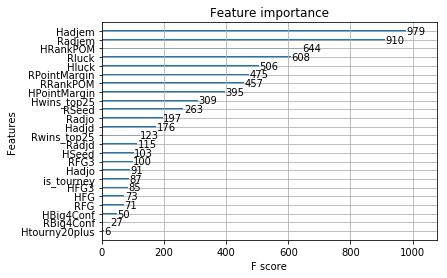

In [47]:
xgb.plot_importance(xgb_train)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [48]:
LogLoss(xgb_valid_prob, y_valid)

0.5179763780211779

Random forest

In [49]:
clf = RandomForestClassifier(n_estimators=200, max_depth=3, min_samples_leaf=3)
clf.fit(X_train, y_train)
rf_prob = pd.DataFrame(clf.predict_proba(X_valid))
LogLoss(rf_prob[1], y_valid)

0.5807195719900436

In [50]:
avg = (rf_prob[1]+xgb_valid_prob+nn_pred)/3

In [51]:
LogLoss(avg, y_valid)

0.5196065131373279